In [12]:
# Imports
from datetime import datetime, timedelta
import statistics
import copy
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import math

In [13]:
# Configs
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": [],
})
title_fontsize = 25
subtitle_fontsize = 23
axes_fontsize = 25
legend_fontsize = 20
tick_labels_fontsize = 20
annotations_fontsize = 20

files = ["measurements/Q4.4/whatever/qpsi=2_jobs_run1.txt", "measurements/Q4.4/whatever/qpsi=2_jobs_run2.txt", "measurements/Q4.4/whatever/qpsi=2_jobs_run4.txt"]
mcperf_files = ["measurements/Q4.4/whatever/qpsi=2_mcperf_run1.txt", "measurements/Q4.4/whatever/qpsi=2_mcperf_run2.txt", "measurements/Q4.4/whatever/qpsi=2_mcperf_run4.txt"]
n_runs = 3
qps_interval = 2

In [14]:
# Function to get the benchmarks execution times for a provided log file (in seconds)
def get_batch_times(files, jobs_names):
    execution_times = {qj: [] for qj in ['radix', 'ferret', 'freqmine', 'canneal', 'vips', 'blackscholes', 'dedup']}
    for i, file in enumerate(files):
        job_names = jobs_names[i]
        start_times = {qj: None for qj in job_names}
        end_times = {qj: None for qj in job_names}
        pause_times = {qj: [] for qj in job_names}
        unpause_times = {qj: [] for qj in job_names}
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                
                if event == 'start' and job in job_names:
                    start_times[job] = datetime.fromisoformat(parts[0])
                if event == 'end' and job in job_names:
                    end_times[job] = datetime.fromisoformat(parts[0])
                if event == 'pause' and job in job_names:
                    pause_times[job].append(datetime.fromisoformat(parts[0]))
                if event == 'unpause' and job in job_names:
                    unpause_times[job].append(datetime.fromisoformat(parts[0]))
                    
        # Compute end - start times for each job, and remove sum of pause spans for each job if present
        for (k, v1), (_, v2) in zip(pause_times.items(), unpause_times.items()):
            if (v1 and v2) and (len(v1) == len(v2)):
                tot_pause = sum([(unp - pau).total_seconds() for unp, pau in zip(v2, v1)])
                execution_times[k].append((end_times[k] - start_times[k]).total_seconds() - tot_pause)
            elif (not v1) and (not v2):
                execution_times[k].append((end_times[k] - start_times[k]).total_seconds())
            else:
                raise ValueError('Pause and Unpause lists are not of the same length OR one is empty and the othe not !')
    return execution_times


# Function to calculate mean and standard deviation of job time for each batch application
def calculate_batch_means_and_stds(files, job_names):
    batch_execution_times = get_batch_times(files, job_names)
    # Create mean and std dictionaries with all key-values: job_name --> mean and job_name --> std
    batch_means = {}
    batch_stds = {}
    for batch_name, execution_times in batch_execution_times.items():
        batch_means[batch_name] = statistics.mean(execution_times)
        batch_stds[batch_name] = statistics.stdev(execution_times)

    return batch_means, batch_stds


def get_total_job_times(files, jobs_nms):
    jobs_makespans = list()
    for i, file in enumerate(files):
        job_names = copy.deepcopy(jobs_nms[i])
        is_first = True
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                if is_first and (event == 'start') and (job in job_names):
                    start_first_job = datetime.fromisoformat(parts[0])
                    is_first = False
                if (event == 'end') and (job in job_names):
                    if len(job_names) == 1 and job_names[0] == job:
                        end_last_job = datetime.fromisoformat(parts[0])
                    else:
                        job_names.remove(job)
        jobs_makespan = (end_last_job - start_first_job).total_seconds()
        jobs_makespans.append(jobs_makespan)
    
    return jobs_makespans


# Function to parse the mcperf file
def parse_mcperf_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        filtered_lines = [line.strip() for line in lines if line.startswith('#type') or line.startswith('read')]
    header = filtered_lines[0].split()
    column_indices = {header[i]: i for i in range(len(header))} # To get automatically the correct columns instead of hardcoding indeces
    data = {'p95': [], 'QPS':[], 'target':[]}
    for line in filtered_lines[1:]:  # To skip the header line
        parts = line.split()
        data['p95'].append(float(parts[column_indices['p95']]))
        data['QPS'].append(float(parts[column_indices['QPS']]))
        data['target'].append(float(parts[column_indices['target']]))
    df = pd.DataFrame(data)
    return df


# Compute SLO violation ration for a given run
def compute_SLO_violation_ratio(p95):
    return (p95/1000.0 > 1).sum() / len(p95)


# Function to arrange times in a format convenient for plotting
def arrange_times(batch_times, total_times, jobs_list, n_runs):
    arranged_times = list()
    for i in range(n_runs):
        tmp = list()
        for job in jobs_list[i]:
            tmp.append(batch_times[job][i])
        tmp.append(total_times[i])
        arranged_times.append(tmp)
    return arranged_times


# Function to calculate relative starting times in seconds for each job
def calculate_relative_start_times(files, jobs_names):
    relative_start_times = list()
    for i, file in enumerate(files):
        job_names = jobs_names[i]
        start_times = list()
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                if (event == 'start') and (job in job_names):
                    start_times.append(datetime.fromisoformat(parts[0]))
        min_start_time = min(start_times)
        relative_start_times.append([(start_time - min_start_time).total_seconds() for start_time in start_times]) 
    return relative_start_times


# Function to get the pauses and unpauses matrices
def get_relative_pauses_unpauses(files, jobs_names):
    relative_pauses = [[[] for _ in range(7)] for _ in range(len(files))]
    relative_unpauses = [[[] for _ in range(7)] for _ in range(len(files))]
    for i, file in enumerate(files):
        job_names = jobs_names[i]
        pflag = False
        start_times = list()
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                if (event == 'start') and (job in job_names):
                    start_times.append(datetime.fromisoformat(parts[0]))
            min_start_time = min(start_times)

        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                if event == 'pause' and (not pflag) and (job in job_names):
                    pause_time = datetime.fromisoformat(parts[0])
                    jname_idx = job_names.index(job)
                    relative_pauses[i][jname_idx].append((pause_time - min_start_time).total_seconds()) 
                    pflag = True
                if event == 'unpause' and pflag and (job in job_names):
                    unpause_time = datetime.fromisoformat(parts[0])
                    jname_idx = job_names.index(job)
                    relative_unpauses[i][jname_idx].append((unpause_time - min_start_time).total_seconds()) 
                    pflag = False   
    return relative_pauses, relative_unpauses


# Function to get the tart and end times from mcperf file
def get_mcperf_start_end(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        filtered_lines = [line.strip() for line in lines if line.startswith('Timestamp')]
        splitted = [elem.split(': ') for elem in filtered_lines]
        timestamps = [int(elem[1])/1000 for elem in splitted]
    return timestamps


# Function to synchronize mcperf and jobs starting points for plotting
def get_start_offsets(df, min_start):
        closest_start = df[df['mcperf_timestamp'] <= min_start]['mcperf_timestamp'].max()
        if isinstance(closest_start, type(pd.NaT)):
            closest_start = min_start
        start_offset = min_start - closest_start
        return start_offset
    

# Function to synchronize mcperf and jobs for plotting
def synch_mcperf_jobs_plot(axis, df, start_offsets, relative_start_times, arranged_times, qps_interval, i):
    xticks = list(np.arange(0, math.ceil(arranged_times[i][-1])+100, 100))
    x_labels = [str(tick) for tick in xticks]
    
    first_timestamp = df['mcperf_timestamp'][0]
    elapsed_times_from_start = (df['mcperf_timestamp'] - first_timestamp).dt.total_seconds()
    memchd_indeces = [t - (start_offsets[i].total_seconds()) for t in elapsed_times_from_start]
    df.index = memchd_indeces
    
    df = df.loc[-5:xticks[-1]]
    axis.set_xticks(xticks, x_labels)
    axis.tick_params(axis='x', labelsize=tick_labels_fontsize)
    axis.set_xlabel('Time [s]', fontsize=axes_fontsize)
    axis.set_xlim(-1, xticks[-1]+1)
    return df

# Function to synchronize core_df with jobs for plotting
def synch_core_df(df, start_offsets, relative_start_times, arranged_times, qps_interval, i):
    xticks = list(range(0, math.ceil((relative_start_times[i][-1] + arranged_times[i][-2]))+100, 100))
    df = df.loc[-5:xticks[-1]]
    return df


# Get first start time and last end time from jobs file
def get_job_first_start_last_end(file, job_names):
    start_times = list()
    end_times = list()
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            event = parts[1]
            job = parts[2]
            if (event == 'start') and (job in job_names):
                start_times.append(datetime.fromisoformat(parts[0]))
            if (event == 'end') and (job in job_names):
                end_times.append(datetime.fromisoformat(parts[0]))
    min_start_time = min(start_times)
    max_end_time = max(end_times)
    return min_start_time, max_end_time


# Function to get the memcached cores updated over time for a given job file
def get_memcached_cores(file):
    timestamps = list()
    n_cores = list()
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            event = parts[1]
            job = parts[2]
            if (event == 'update_cores') and job == 'memcached':
                timestamps.append(datetime.fromisoformat(parts[0]))
                n_cores.append(len(ast.literal_eval(parts[3])))
    
    df = pd.DataFrame({'timestamp': timestamps, 'ncores': n_cores})
    return df


# Function to get the mcperf df slice between start first PARSEC container and end last PARSEC container
def filter_mcperf(df, min_start, max_end):
    df_filtered = df.loc[(df['mcperf_timestamp'] >= min_start) & (df['mcperf_timestamp'] <= max_end)]
    return df_filtered


# Function to get the jobs in order of appearance in log file (start)
def get_jobs_start_order(file):
    jnames = ['radix', 'ferret', 'freqmine', 'canneal', 'vips', 'blackscholes', 'dedup']
    jobs = list()
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            event = parts[1]
            job = parts[2]
            if (event == 'start') and (job in jnames):
                jobs.append(job)
                jnames.remove(job)
    return jobs

In [15]:
# Get the job list for each file in order of appearance (start)
jobs_list = list()
for jfile in files:
    jobs_list.append(get_jobs_start_order(jfile))


# Calculate mean and std for batch times across the runs
batch_times = get_batch_times(files, jobs_list)
batch_means, batch_stds = calculate_batch_means_and_stds(files, jobs_list)

print('Batch Application Means:')
for batch_name, mean in batch_means.items():
    print(f'- {batch_name}: {mean:.2f} seconds')
    
print('\nBatch Application Stds:')
for batch_name, std in batch_stds.items():
    print(f'- {batch_name}: {std:.2f} seconds')

# Calculate mean and standard deviation of the total time to complete all jobs (makespan)
total_job_times = get_total_job_times(files, jobs_list)
print('\nTotal Job Time Across All Files:', total_job_times)

makespan_mean = statistics.mean(total_job_times)
makespan_stdev = statistics.stdev(total_job_times)
print(f'\nMakespan Mean: {makespan_mean:.2f} seconds')
print(f'Makespan Standard Deviation: {makespan_stdev:.2f} seconds')


# Compute SLO Violation ratio
violation_ratios = list()
for mcperf, job, job_lst in zip(mcperf_files, files, jobs_list):
    df = parse_mcperf_file(mcperf)
    # We need to compute the SLO violation ratio between start first PARSEC container and end last PARSEC container
    nrows = len(df)
    mcperf_start, mcperf_end = get_mcperf_start_end(mcperf)
    df['mcperf_timestamp'] = [datetime.fromtimestamp(t) - timedelta(hours=2) for t in list(np.linspace(mcperf_start, mcperf_end, nrows))]
    min_start, max_end = get_job_first_start_last_end(job, job_lst)
    #print()
    #print(max_end - min_start)
    df_filtered = filter_mcperf(df, min_start, max_end)
    
    violation_ratios.append(compute_SLO_violation_ratio(df_filtered['p95']))
print('\nSLO Violation Ratios:', [str(round(vr*100, 2))+'%' for vr in violation_ratios])

Batch Application Means:
- radix: 53.40 seconds
- ferret: 305.96 seconds
- freqmine: 521.80 seconds
- canneal: 351.53 seconds
- vips: 110.60 seconds
- blackscholes: 128.92 seconds
- dedup: 58.26 seconds

Batch Application Stds:
- radix: 13.18 seconds
- ferret: 29.78 seconds
- freqmine: 6.41 seconds
- canneal: 21.56 seconds
- vips: 3.78 seconds
- blackscholes: 5.51 seconds
- dedup: 7.19 seconds

Total Job Time Across All Files: [795.283324, 776.72906, 790.912788]

Makespan Mean: 787.64 seconds
Makespan Standard Deviation: 9.70 seconds

SLO Violation Ratios: ['1.01%', '1.55%', '1.78%']


In [16]:
# Get the batch times and the total times across all runs
batch_times = get_batch_times(files, jobs_list)
total_times = get_total_job_times(files, jobs_list)

# Arrange times for convenient plotting
arranged_times = arrange_times(batch_times, total_times, jobs_list, n_runs)

# Get the pauses and unpauses datetimes (3x7 matrix)
pauses, unpauses = get_relative_pauses_unpauses(files, jobs_list)

# Get dataframes of interest from mcperf files and compute memcached timespan
mcperf_dfs = list()
start_offsets = list()
min_starts = list()
ncore_dfs = list()
for mcperf_file, job_file, job_names in zip(mcperf_files, files, jobs_list):
    mcperf_start, mcperf_end = get_mcperf_start_end(mcperf_file)
    df = parse_mcperf_file(mcperf_file)
    nrows = len(df)
    
    # For plot A
    df['mcperf_timestamp'] = [datetime.fromtimestamp(t) - timedelta(hours=2) for t in list(np.linspace(mcperf_start, mcperf_end, nrows))]
    min_start, _ = get_job_first_start_last_end(job_file, job_names)
    min_starts.append(min_start)
    start_offset = get_start_offsets(df, min_start)
    mcperf_dfs.append(df)
    start_offsets.append(start_offset)
    
    # For plot B
    ncore_df = get_memcached_cores(job_file)
    ncore_df['timestamp'] = (ncore_df['timestamp'] - (datetime.fromtimestamp(mcperf_start) - timedelta(hours=2))).dt.total_seconds()
    ncore_dfs.append(ncore_df)

# Get the relative job time spans wrt the first run job(s)
relative_start_times = calculate_relative_start_times(files, jobs_list)

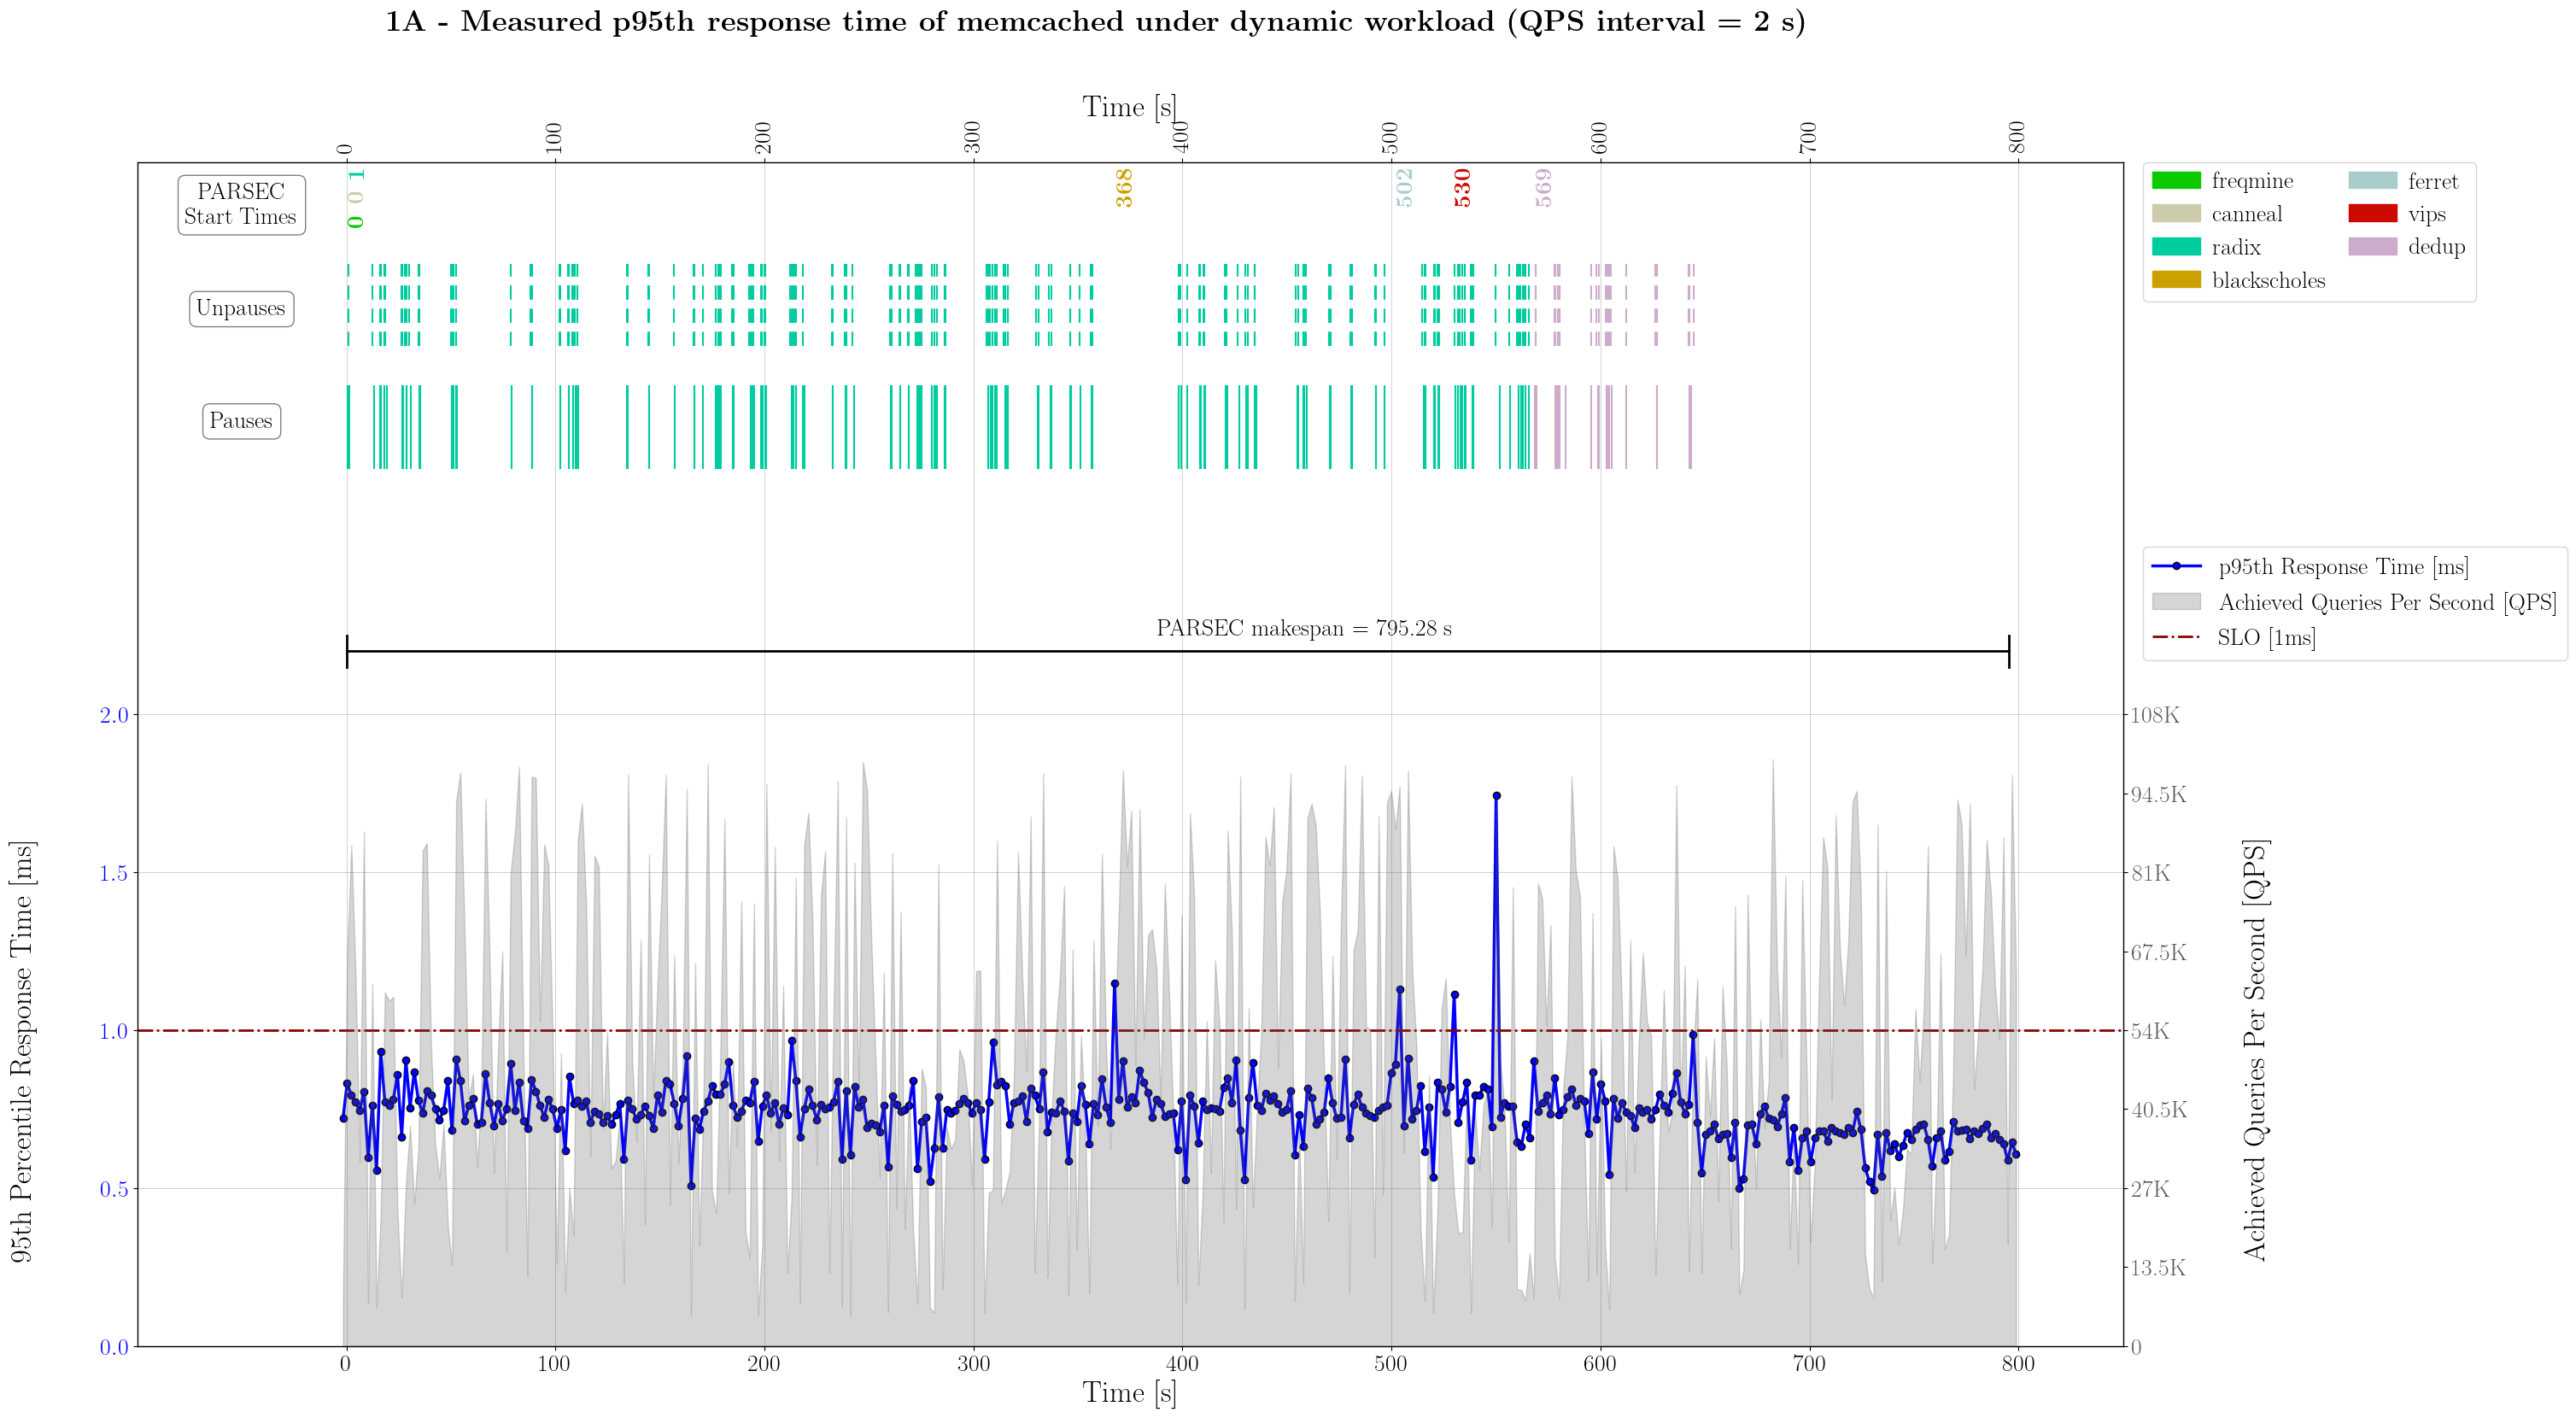

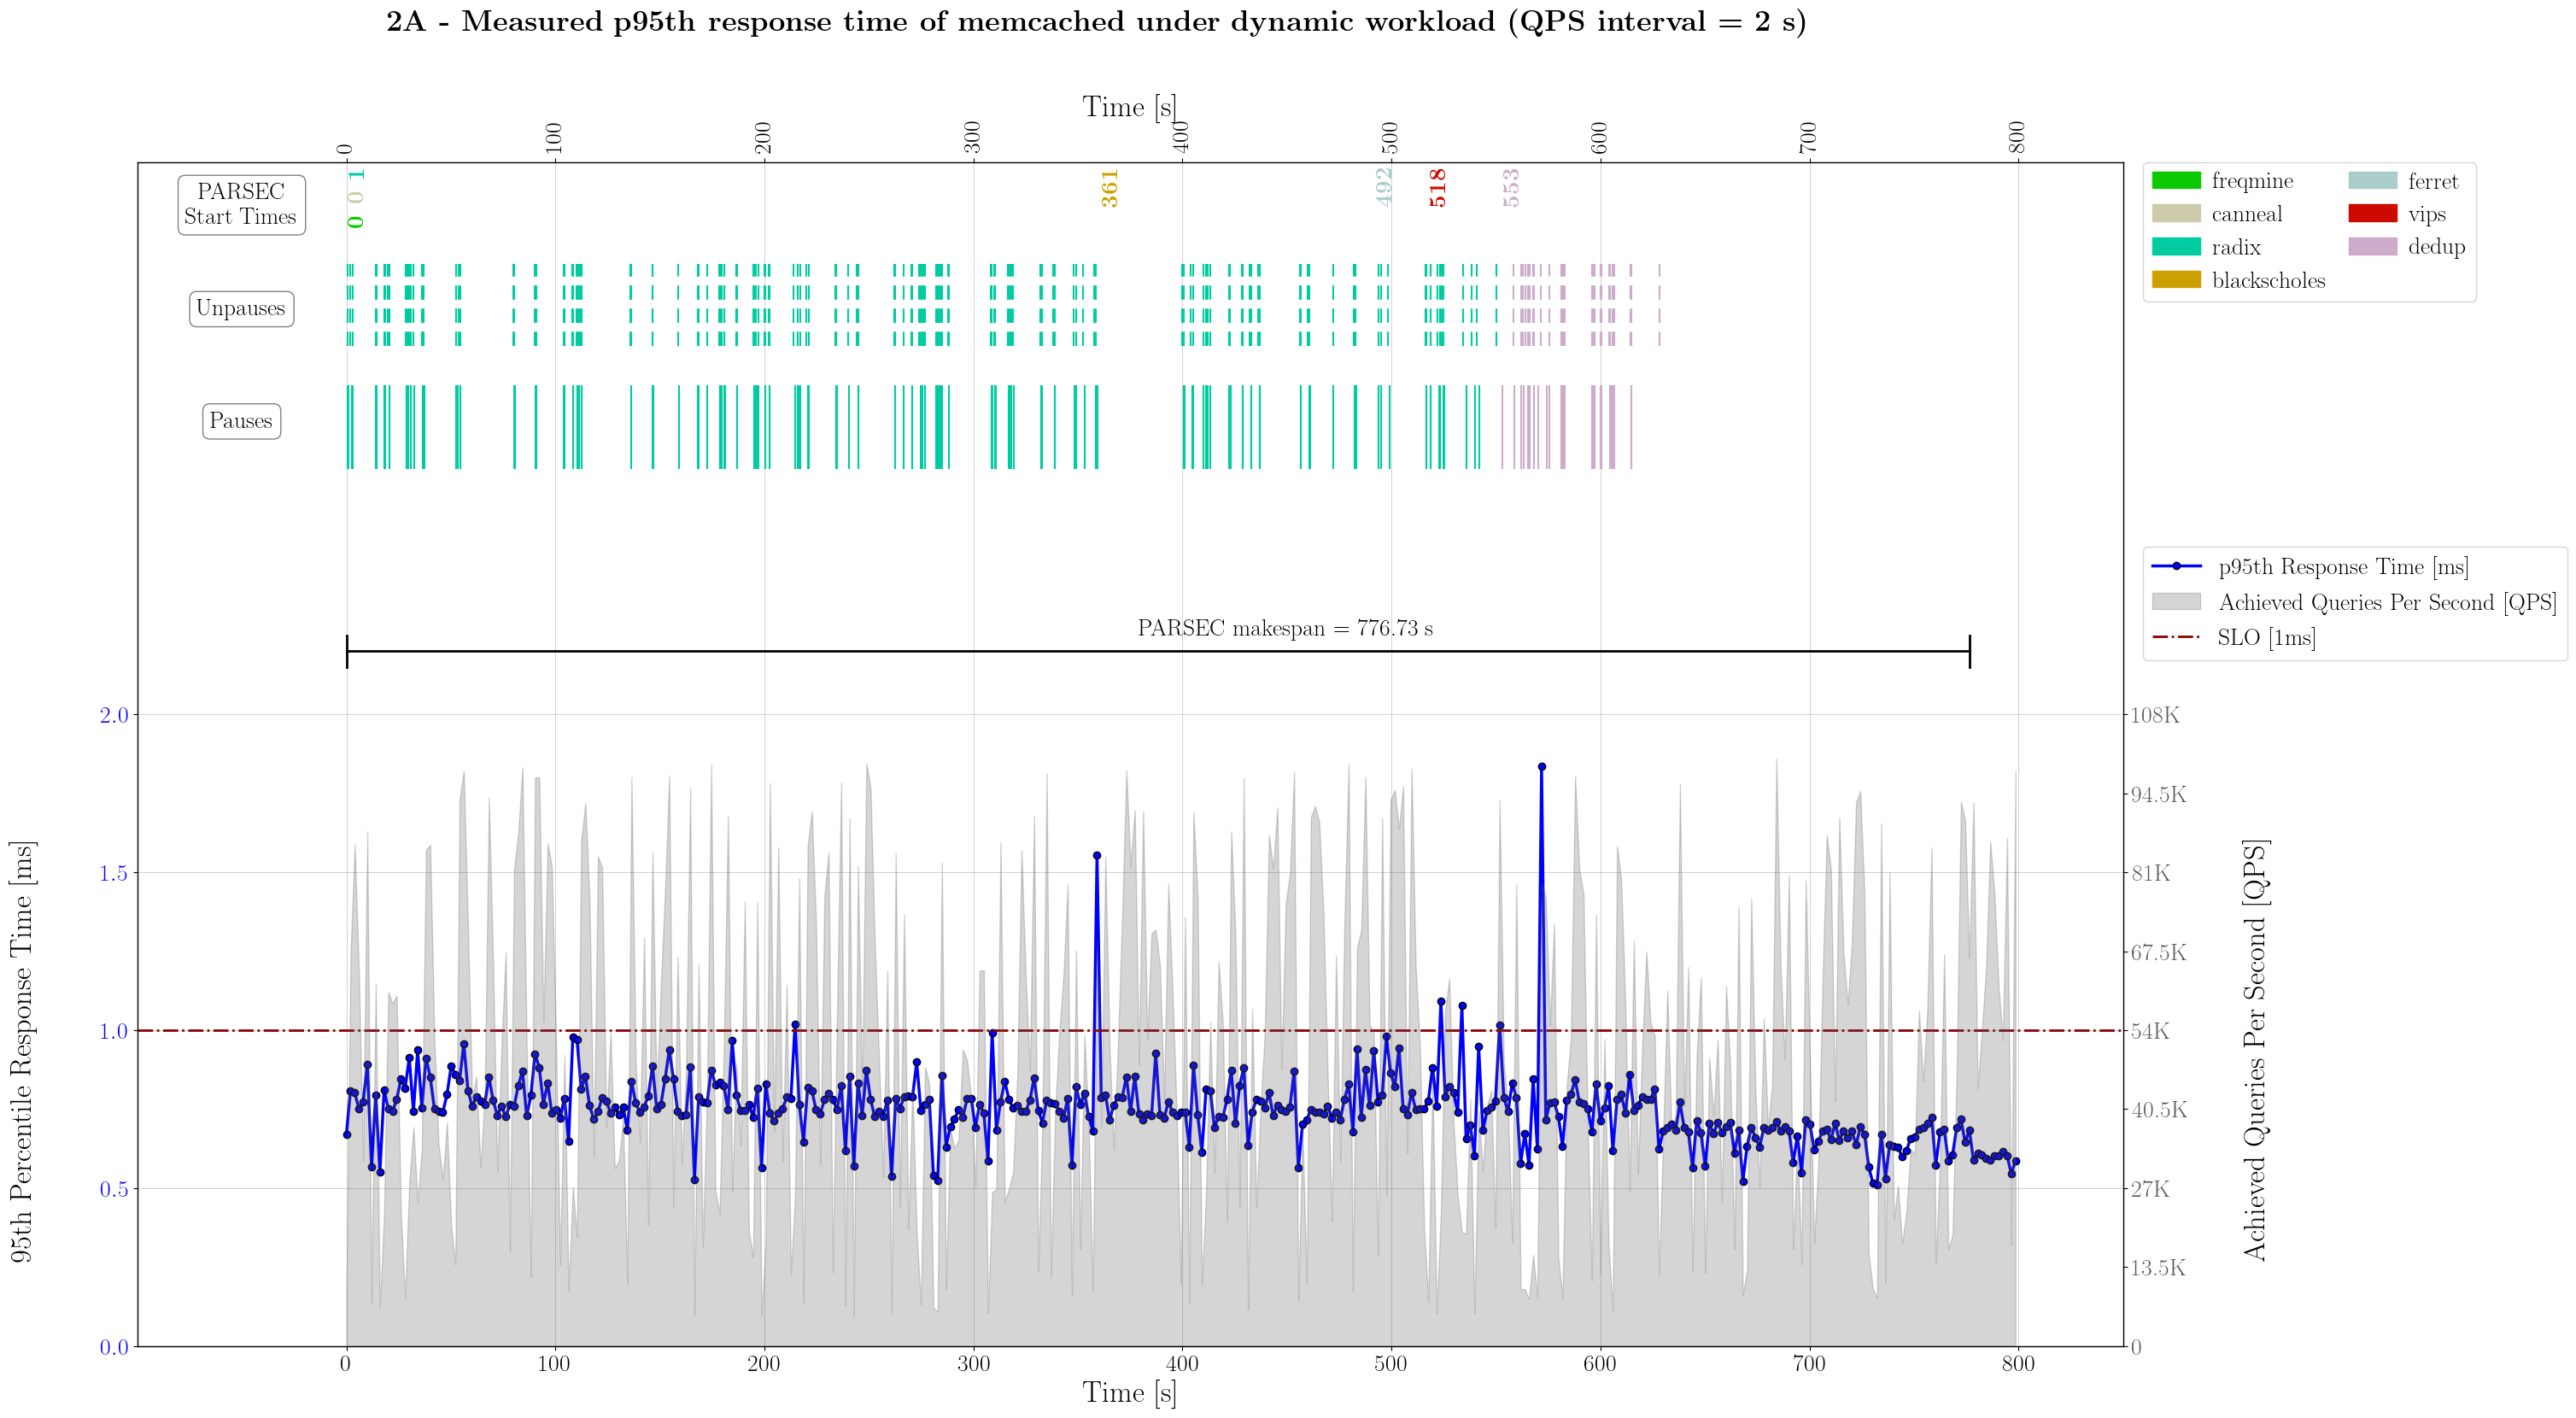

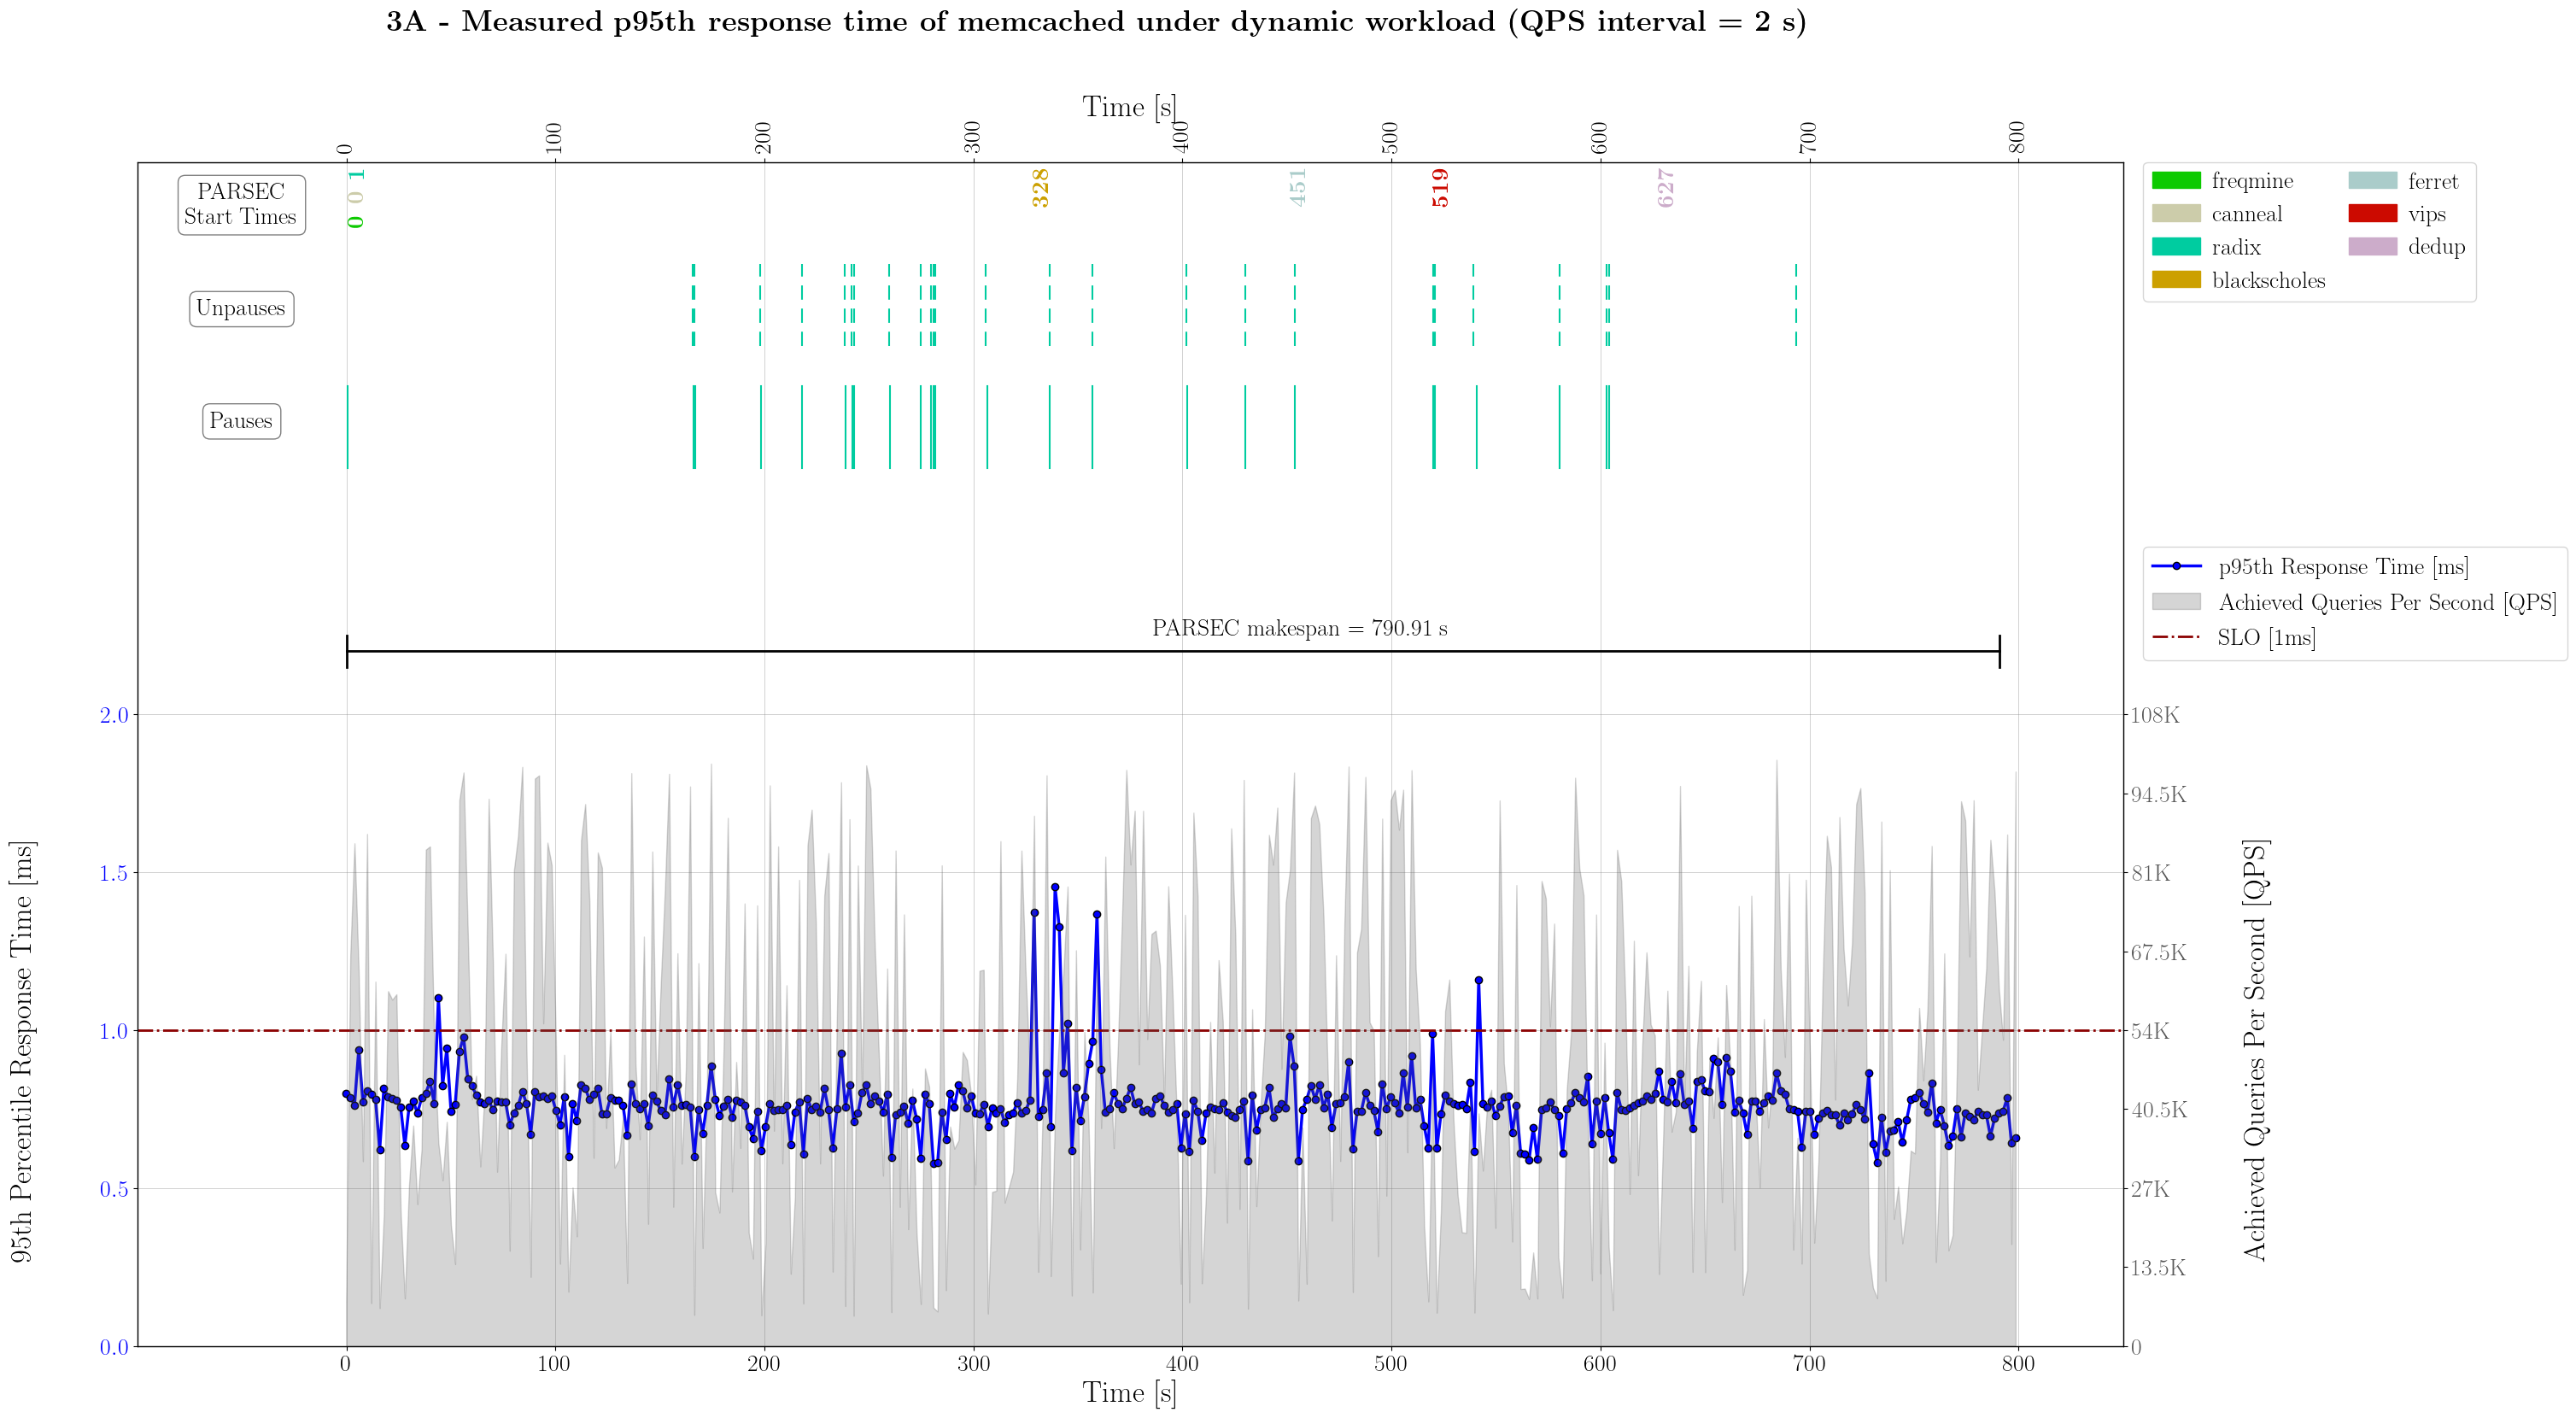

In [17]:
# Plots (A)
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': 'grey', 'radix': '#00CCA0', 'vips': '#CC0A00'}
legend_dict = {'p95' : 'p95th Response Time [ms]', 'qps' : 'Achieved Queries Per Second [QPS]'}

pauses_normalized = copy.deepcopy(pauses)
for i in range(len(pauses_normalized)):
        for j in range(len(pauses_normalized[i])):
                for k in range(len(pauses_normalized[i][j])):
                        pauses_normalized[i][j][k] = pauses_normalized[i][j][k]
                        
unpauses_normalized = copy.deepcopy(unpauses)
for i in range(len(unpauses_normalized)):
        for j in range(len(unpauses_normalized[i])):
                for k in range(len(unpauses_normalized[i][j])):
                        unpauses_normalized[i][j][k] = unpauses_normalized[i][j][k]

for i, df in enumerate(copy.deepcopy(mcperf_dfs)):
        fig, ax3 = plt.subplots(figsize=(30, 18))

        ax3.set_ylim(-20)
        ax3.set_yticks([i for i in range(10)])
        ax3.set_yticks([])
        ax1 = ax3.twinx()   

        df = synch_mcperf_jobs_plot(ax3, df, start_offsets, relative_start_times, arranged_times, qps_interval, i)
        
        ## ------ First Subplot ------ ##
        p95_line = ax1.plot(df.index, df['p95']/1000, marker='o', linewidth=2.5, alpha=1, markersize=6, 
                        color='#0000ff', markeredgewidth=1, markeredgecolor='black', zorder=3, label=legend_dict['p95'])[0]
        
        ax1.set_ylim((0, 3.75))
        ax1.yaxis.tick_left()
        ax1.set_yticks(np.arange(0, 2.1, 0.5).tolist())
        ax1.yaxis.set_label_position('left')
        ax1.set_ylabel('95th Percentile Response Time [ms]', fontsize=axes_fontsize)
        ax1.tick_params(axis='y', labelcolor='#0000ff', labelsize=tick_labels_fontsize)
        ax1.yaxis.set_label_coords(-0.05, 0.25)

        ax2 = ax3.twinx()

        qps_line = ax2.fill_between(df.index, df['QPS'], color='#585858', alpha=0.25, zorder=0, label=legend_dict['qps'])

        y2_labels = ['0', '13.5K', '27K', '40.5K', '54K', '67.5K', '81K', '94.5K', '108K']
        ax2.set_xlim((-100, ax3.get_xticks()[-1]+50))
        ax2.set_ylim((0, 202500))
        ax2.set_yticks(range(0, 108001, 13500), y2_labels)
        ax2.set_ylabel('Achieved Queries Per Second [QPS]', fontsize=axes_fontsize)
        ax2.tick_params(axis='y', labelcolor='#585858', labelsize=tick_labels_fontsize)
        ax2.yaxis.set_label_coords(1.06, 0.25)

        # Jobs
        ax3_top = ax3.twiny()
        new_ticks = list()
        new_labels = list()
        offs = 0
        for j, job in enumerate(jobs_list[i]):
                job_color = colors[job]
                start_time = relative_start_times[i][j]
                
                new_ticks.append(round(start_time, 2))
                new_labels.append(round(start_time, 2))

                for p in pauses_normalized[i][j]:
                        line = Line2D([p, p], [1.5, 3.5], color=job_color, linestyle='solid', linewidth=1.5, zorder=4)
                        ax3.add_line(line)
                for u in unpauses_normalized[i][j]:
                        line = Line2D([u, u], [4.5, 6.5], color=job_color, linestyle=(0, (8, 5)), linewidth=1.5, zorder=4)
                        ax3.add_line(line)
                
                # Annotating the start time on ax3_top
                if round(start_time) < 5:
                        annot = f'{round(start_time)}'
                        ax3_top.annotate(r"\bf{" + annot + "}", xy=(start_time, 7.5 + offs), 
                                 color=job_color, rotation=90, fontsize=annotations_fontsize, fontweight='bold')
                        offs += 0.6
                else:
                        annot = f'{round(start_time)}'
                        ax3_top.annotate(r"\bf{" + annot + "}", xy=(start_time, 8.0), 
                                 color=job_color, rotation=90, fontsize=annotations_fontsize, fontweight='bold')
        
        # SLO line
        slo_objective = ax1.axhline(y=1, color='darkred', linestyle='dashdot', linewidth=2, zorder=10)
                   
        # Makespan line
        ax1.plot([0, total_times[i]], [2.2, 2.2], color='black', linestyle='-', linewidth=2, zorder=10)
        ax1.plot([0, 0], [2.25, 2.15], color='black', linestyle='-', linewidth=2, zorder=10)
        ax1.plot([total_times[i], total_times[i]], [2.25, 2.15], color='black', linestyle='-', linewidth=2, zorder=10)
        ax1.annotate(f'PARSEC makespan = {total_times[i]:.2f} s', 
                     xy=((total_times[i])/2-len(f'makespan = {total_times[i]:.2f} s')/2, 2.25), 
                     color='black', fontsize=annotations_fontsize, zorder=10)
        
        # Legends
        lines = [p95_line, qps_line, slo_objective]
        labels = [line.get_label() for line in lines]
        labels[-1] = 'SLO [1ms]'
        
        ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.01, 0.675), title_fontsize=legend_fontsize, fontsize=legend_fontsize, borderaxespad=0)
        
        job_patches = [Patch(color=colors[job], label=job) for job in jobs_list[i]]
        job_legend = ax2.legend(handles=job_patches, loc='upper left', bbox_to_anchor=(1.01, 1), 
                                title_fontsize=legend_fontsize, fontsize=legend_fontsize, borderaxespad=0, ncol=2, handletextpad=0.5, columnspacing=1)
        
        #ax3top
        ax3_top.annotate(f'PARSEC \nStart Times',  xy=(-50, 7.5), color='black', 
                         bbox=dict(boxstyle='round', fc='white', alpha=0.5), ha='center', fontsize=annotations_fontsize, zorder=10)
        ax3_top.annotate(f'Unpauses',  xy=(-50, 5.25), color='black', 
                         bbox=dict(boxstyle='round', fc='white', alpha=0.5), ha='center', fontsize=annotations_fontsize, zorder=10)
        ax3_top.annotate(f'Pauses',  xy=(-50, 2.5), color='black', 
                         bbox=dict(boxstyle='round', fc='white', alpha=0.5), ha='center', fontsize=annotations_fontsize, zorder=10)
        # Style
        ax3_top.set_xlim(ax3.get_xlim())
        ax3_top.set_xticks(ax3.get_xticks())
        ax3_top_labels = ax3.get_xticklabels()
        ax3_top.set_xticklabels(ax3_top_labels, rotation=90)
        ax3_top.tick_params(axis='x', labelsize=tick_labels_fontsize)
        ax3_top.set_xlabel('Time [s]', fontsize=axes_fontsize)
        
        ax3_top.grid(False)
        ax3.grid(color='grey', linewidth=0.5, alpha=0.5, zorder=0)

        ax1.grid(color='grey', linewidth=0.5, alpha=0.5, zorder=0)
        title_text = f"{i+1}A - Measured p95th response time of memcached under dynamic workload (QPS interval = {qps_interval} s)"
        fig.suptitle(r"\bf{" + title_text + "}", fontsize=title_fontsize)
    
        #plt.show()
        plt.savefig("plots/plot4_4_A" + str(i+1) + ".pdf", bbox_inches = "tight")

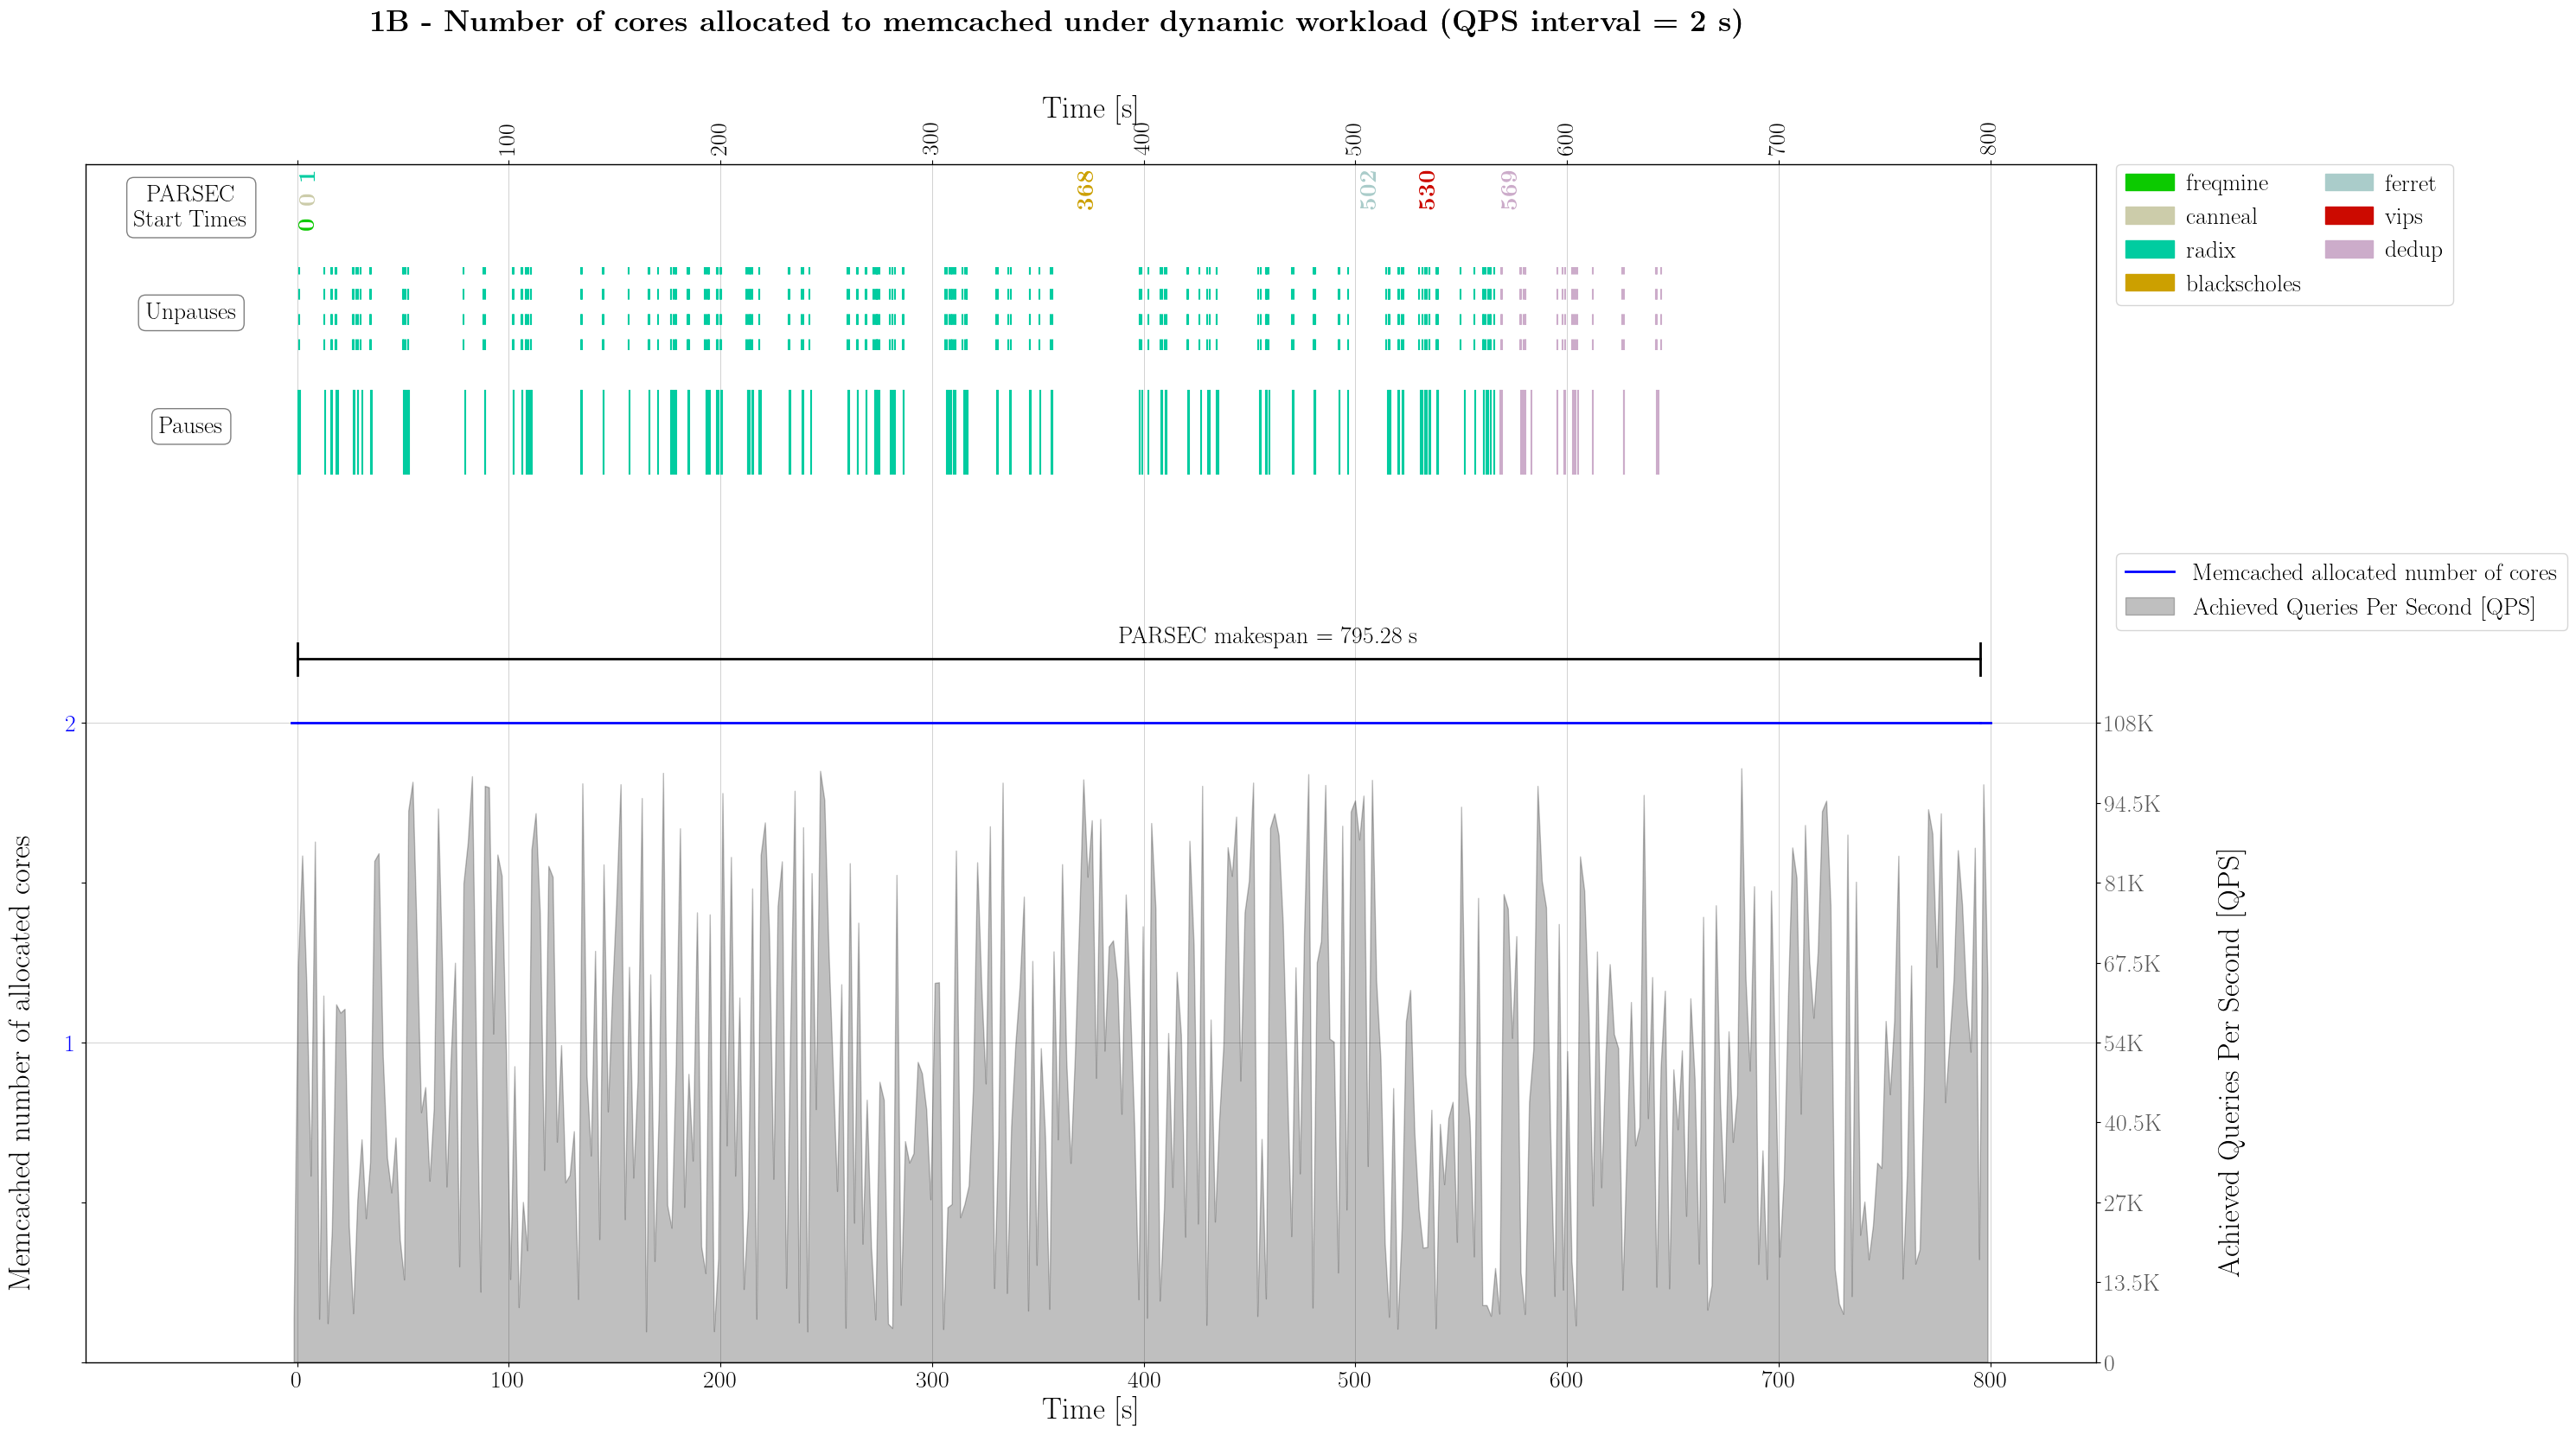

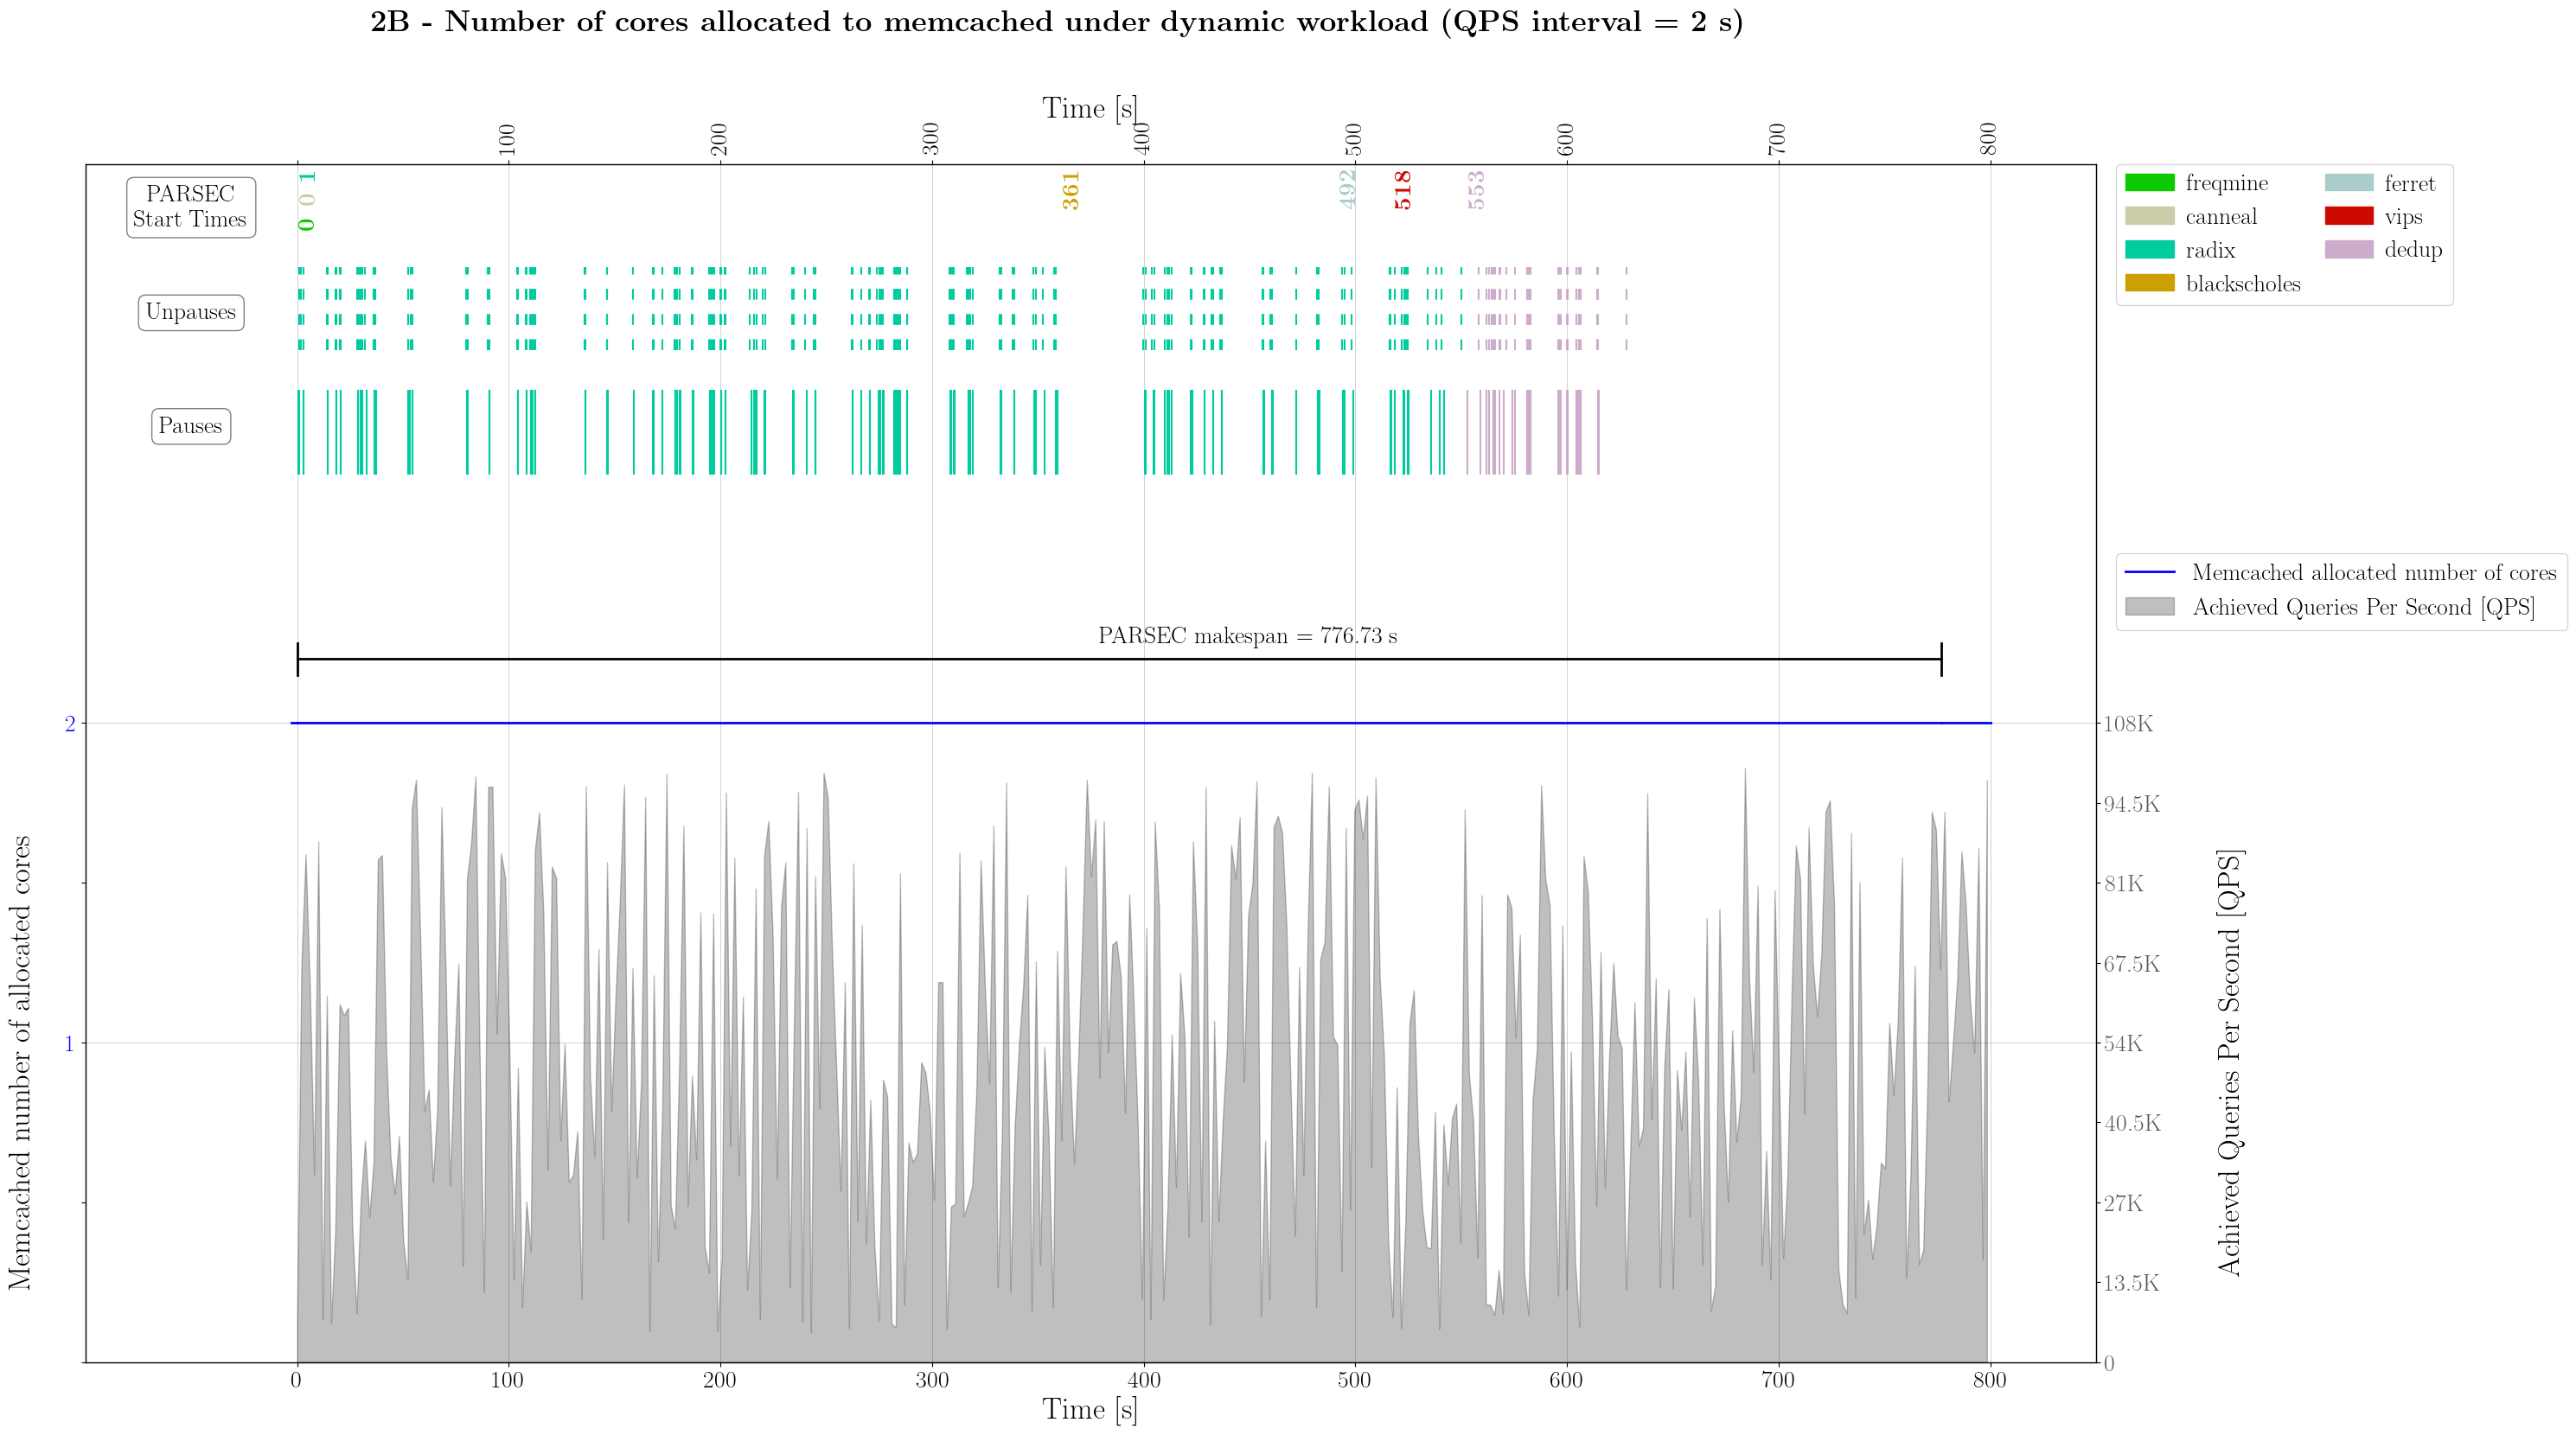

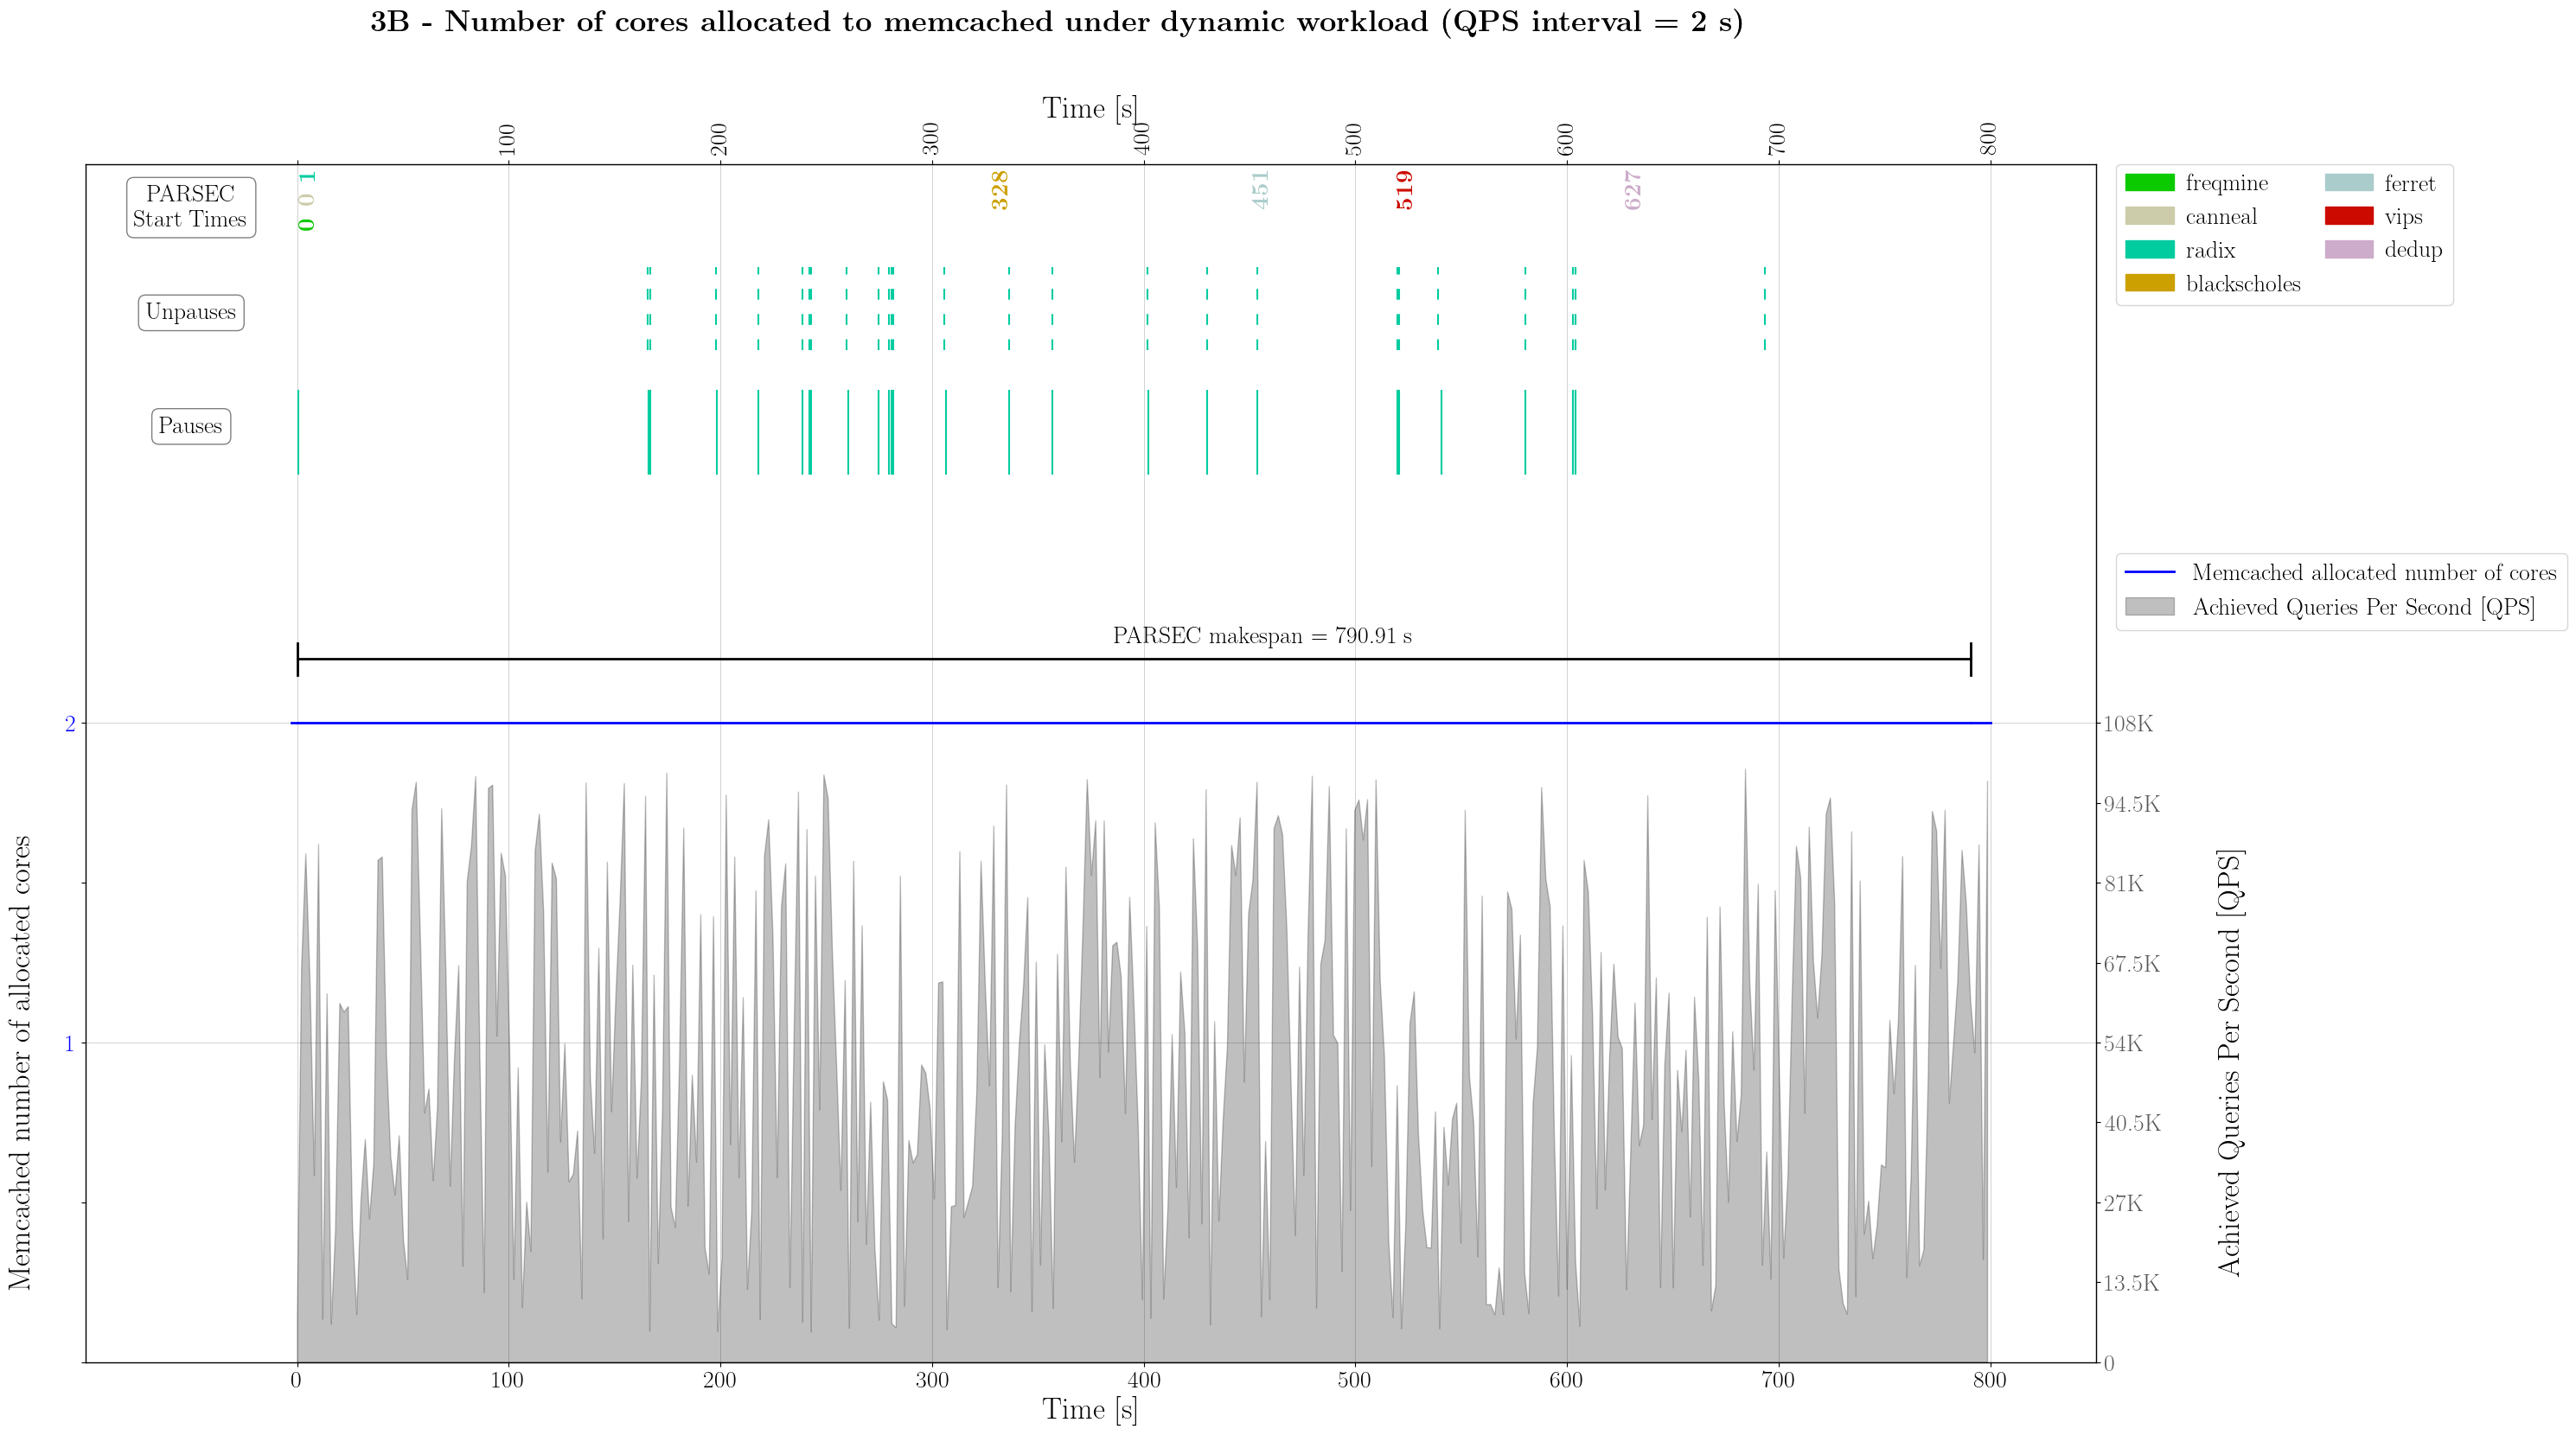

In [18]:
# Plots (B)
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': 'grey', 'radix': '#00CCA0', 'vips': '#CC0A00'}
legend_dict = {'ncores' : 'Memcached allocated number of cores', 'qps' : 'Achieved Queries Per Second [QPS]'}

pauses_normalized = copy.deepcopy(pauses)
for i in range(len(pauses_normalized)):
        for j in range(len(pauses_normalized[i])):
                for k in range(len(pauses_normalized[i][j])):
                        pauses_normalized[i][j][k] = pauses_normalized[i][j][k]
                        
unpauses_normalized = copy.deepcopy(unpauses)
for i in range(len(unpauses_normalized)):
        for j in range(len(unpauses_normalized[i])):
                for k in range(len(unpauses_normalized[i][j])):
                        unpauses_normalized[i][j][k] = unpauses_normalized[i][j][k]

for i, (df, core_df) in enumerate(zip(copy.deepcopy(mcperf_dfs), copy.deepcopy(ncore_dfs))):
        fig, ax3 = plt.subplots(figsize=(30, 18))

        ax3.set_ylim(-20)
        ax3.set_yticks([i for i in range(10)])
        ax3.set_yticks([])
        ax1 = ax3.twinx()   

        df = synch_mcperf_jobs_plot(ax3, df, start_offsets, relative_start_times, arranged_times, qps_interval, i)
        
        ## ------ First Subplot ------ ##
        #ncores_line = ax1.step(core_df['timestamp']/qps_interval, core_df['ncores'], where='post', 
                               #label=legend_dict['ncores'], color='blue', linewidth=2)[0]
        
        # Horizontal line before start first comtainer
        ax1.plot([-2.5, 0], 
                [2, 2], 
                color='blue', linestyle='-', linewidth=2)
        
        # Vertical line start first container
        #ncores_line = ax1.plot([0, 0], 
                #[1, 2], 
                #color='blue', linestyle='-', linewidth=2, label=legend_dict['ncores'])[0]
        
        # Constant 2 cores horizontal line
        ncores_line = ax1.plot([0, total_times[i]], 
                 [2, 2], 
                 color='blue', linestyle='-', linewidth=2, label=legend_dict['ncores'])[0]
        
        # Vertical line finish last container
        #ax1.plot([total_times[i]/qps_interval, total_times[i]/qps_interval], 
                 #[1, 2], 
                 #color='blue', linestyle='-', linewidth=2)
        
        # Horizontal line after end last container
        ax1.plot([total_times[i], ax3.get_xticks()[-1]], 
                [2, 2], 
                color='blue', linestyle='-', linewidth=2)
        
        
        ax1.set_ylim((0, 3.75))
        ax1.yaxis.tick_left()
        yticks = np.arange(0, 2.1, 0.5).tolist()
        ax1.set_yticks(yticks, ['', '', '1', '', '2'])
        ax1.yaxis.set_label_position('left')
        ax1.set_ylabel('Memcached number of allocated cores', fontsize=axes_fontsize)
        ax1.tick_params(axis='y', labelcolor='#0000ff', labelsize=tick_labels_fontsize)
        ax1.yaxis.set_label_coords(-0.025, 0.25)
        
        # Custom grid
        ax1.yaxis.grid(False)
        for tick in yticks:
                if tick == 1 or tick == 2:
                        ax1.axhline(y=tick, color='grey', linewidth=0.5, alpha=0.5, zorder=0)

        ax2 = ax3.twinx()

        qps_line = ax2.fill_between(df.index, df['QPS'], color='black', alpha=0.25, zorder=1, label=legend_dict['qps'])

        y2_labels = ['0', '13.5K', '27K', '40.5K', '54K', '67.5K', '81K', '94.5K', '108K']
        ax2.set_xlim((-100, ax3.get_xticks()[-1]+50))
        ax2.set_ylim((0, 202500))
        ax2.set_yticks(range(0, 108001, 13500), y2_labels)
        ax2.set_ylabel('Achieved Queries Per Second [QPS]', fontsize=axes_fontsize)
        ax2.tick_params(axis='y', labelcolor='#585858', labelsize=tick_labels_fontsize)
        ax2.yaxis.set_label_coords(1.06, 0.25)

        # Jobs
        ax3_top = ax3.twiny()
        new_ticks = list()
        new_labels = list()
        offs = 0
        for j, job in enumerate(jobs_list[i]):
                job_color = colors[job]
                start_time = relative_start_times[i][j]

                for p in pauses_normalized[i][j]:
                        line = Line2D([p, p], [1.5, 3.5], color=job_color, linestyle='solid', linewidth=1.5, zorder=4)
                        ax3.add_line(line)
                for u in unpauses_normalized[i][j]:
                        line = Line2D([u, u], [4.5, 6.5], color=job_color, linestyle=(0, (6, 8)), linewidth=1.5, zorder=4)
                        ax3.add_line(line)
                
                # Annotating the start time on ax3_top
                if round(start_time) < 5:
                        annot = f'{round(start_time)}'
                        ax3_top.annotate(r"\bf{" + annot + "}", xy=(start_time, 7.5 + offs),
                                 color=job_color, rotation=90, fontsize=annotations_fontsize, fontweight='bold')
                        offs += 0.6
                else:
                        annot = f'{round(start_time)}'
                        ax3_top.annotate(r"\bf{" + annot + "}", xy=(start_time, 8.0),  
                                 color=job_color, rotation=90, fontsize=annotations_fontsize, fontweight='bold')
                   
        # Makespan line
        ax1.plot([0, total_times[i]], [2.2, 2.2], color='black', linestyle='-', linewidth=2, zorder=10)
        ax1.plot([0, 0], [2.25, 2.15], color='black', linestyle='-', linewidth=2, zorder=10)
        ax1.plot([total_times[i], total_times[i]], [2.25, 2.15], color='black', linestyle='-', linewidth=2, zorder=10)
        ax1.annotate(f'PARSEC makespan = {total_times[i]:.2f} s', 
                     xy=((total_times[i])/2-len(f'makespan = {total_times[i]:.2f} s')/2, 2.25), 
                     color='black', fontsize=annotations_fontsize, zorder=10)
        
        # Legends
        lines = [ncores_line, qps_line]
        labels = [line.get_label() for line in lines]
        
        ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.01, 0.675), title_fontsize=legend_fontsize, fontsize=legend_fontsize, borderaxespad=0)
        
        job_patches = [Patch(color=colors[job], label=job) for job in jobs_list[i]]
        job_legend = ax2.legend(handles=job_patches, loc='upper left', bbox_to_anchor=(1.01, 1), 
                                title_fontsize=legend_fontsize, fontsize=legend_fontsize, borderaxespad=0, ncol=2, handletextpad=0.5, columnspacing=1)
        
        #ax3top
        ax3_top.annotate(f'PARSEC \nStart Times',  xy=(-50, 7.5), color='black', 
                         bbox=dict(boxstyle='round', fc='white', alpha=0.5), ha='center', fontsize=annotations_fontsize, zorder=10)
        ax3_top.annotate(f'Unpauses',  xy=(-50, 5.25), color='black', 
                         bbox=dict(boxstyle='round', fc='white', alpha=0.5), ha='center', fontsize=annotations_fontsize, zorder=10)
        ax3_top.annotate(f'Pauses',  xy=(-50, 2.5), color='black', 
                         bbox=dict(boxstyle='round', fc='white', alpha=0.5), ha='center', fontsize=annotations_fontsize, zorder=10)
        # Style
        ax3_top.set_xlim(ax3.get_xlim())
        ax3_top.set_xticks(ax3.get_xticks())
        ax3_top_labels = ax3.get_xticklabels()
        ax3_top_labels[0] = ''
        ax3_top.set_xticklabels(ax3_top_labels, rotation=90)
        ax3_top.tick_params(axis='x', labelsize=tick_labels_fontsize)
        ax3_top.set_xlabel('Time [s]', fontsize=axes_fontsize)
        
        ax3_top.grid(False)
        ax3.grid(color='grey', linewidth=0.5, alpha=0.5, zorder=0)
        title_text = f'{i+1}B - Number of cores allocated to memcached under dynamic workload (QPS interval = {qps_interval} s)'
        fig.suptitle(r"\bf{" + title_text + "}", fontsize=title_fontsize)
    
        #plt.show()
        plt.savefig("plots/plot4_4_B" + str(i+1) + ".pdf", bbox_inches = "tight")